# Spis treści
1. [Wstęp](#wstęp)
2. [Połączenie z bazą](#połączenie-z-bazą)
3. [Analiza danych](#analiza-danych)
    - [a) Popularność atrakcji](#a-które-atrakcje-są-najpopularniejsze)
    - [b) Trend klientów](#b-analiza-trendu-klientów)
    - [c) Analiza bezpieczeństwa](#c-analiza-bezpieczeństwa)
    - [d) Profil wiekowy gości](#d-analiza-wieku-klientów)
    - [e) Koszty napraw i awaryjność](#e-analiza-techniczna)
    - [f) VR vs Tradycyjne](#czy-atrakcje-vr-generują-większy-przychód-niż-tradycyjne)
4. [Wnioski końcowe](#wnioski-końcowe)


# Analiza danych parku rozrywki AiBtcQuantLandia
## 1. Wstęp

Raport przedstawia analizę danych zgromadzonych w relacyjnej bazie danych
parku rozrywki **AiBtcQuantLandia**.

Celem raportu jest:
- analiza popularności atrakcji,
- porównanie kosztów i przychodów działalności,
- ocena liczby odwiedzających na przestrzeni czasu.

**Wszystkie wyniki, wykresy oraz wnioski są generowane automatycznie**
na podstawie aktualnego stanu bazy danych.  
Zmiana danych wejściowych powoduje automatyczną aktualizację raportu.

## 2. Połączenie z bazą
Analiza opiera się na danych przechowywanych w relacyjnej bazie danych MySQL.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from budowa import Baza 

try:
    baza = Baza()
    print("Pomyślnie połączono z bazą AiBtcQuantLandia.")
except Exception as e:
    print(f"Błąd połączenia: {e}")


Pomyślnie połączono z bazą AiBtcQuantLandia.


## 3. Analiza danych 
### a) Które atrakcje są najpopularniejsze i czy przynoszą zyski?

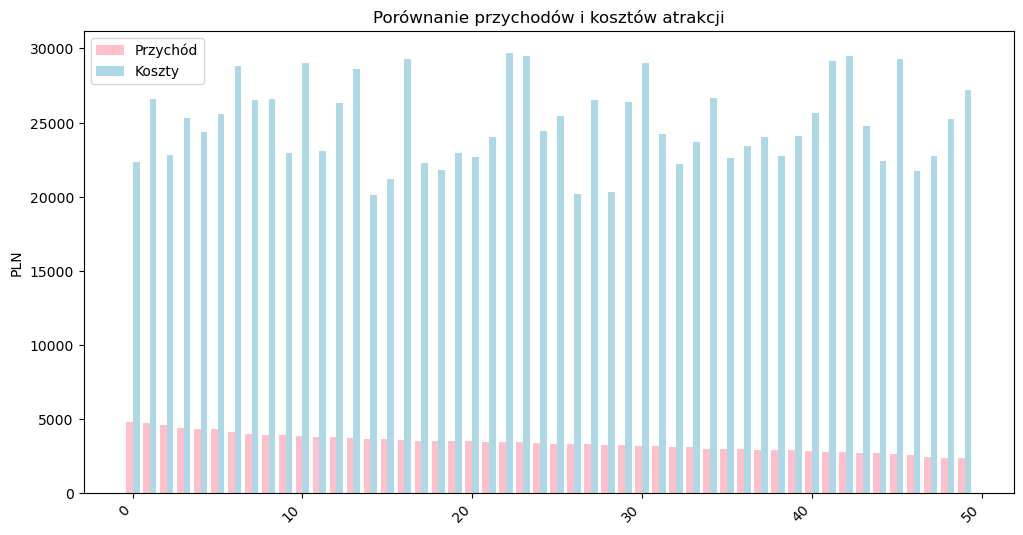

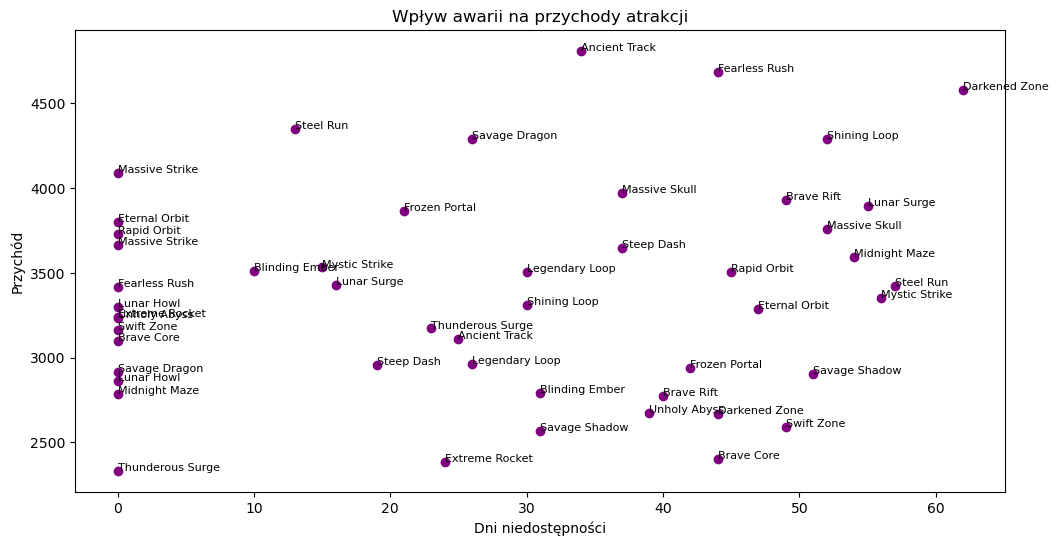

WNIOSKI
Najbardziej problematyczna: Darkened Zone (62 dni niedostępności)
Najbardziej opłacalna: Massive Strike (Zysk: -16438.35)
Najmniej opłacalna: Brave Rift (Zysk: -26689.56)


In [ ]:

query = """
SELECT
    a.attraction_name,
    COALESCE(t.sprzedane_bilety, 0) AS sprzedane_bilety,
    COALESCE(t.przychod, 0) AS przychod,
    COALESCE(c.koszty, 0) AS koszty,
    COALESCE(m.dni_niedostepnosci, 0) AS dni_niedostepnosci
FROM attractions a
LEFT JOIN (
    SELECT
        pr.attraction_id,
        COUNT(pt.ticket_id) AS sprzedane_bilety,
        SUM(p.amount) AS przychod
    FROM prices pr
    JOIN payment_ticket pt ON pr.ticket_id = pt.ticket_id
    JOIN payments p ON pt.payment_id = p.payment_id
    GROUP BY pr.attraction_id
) t ON a.attraction_id = t.attraction_id

LEFT JOIN (
    SELECT
        attraction_id,
        SUM(amount) AS koszty
    FROM costs
    GROUP BY attraction_id
) c ON a.attraction_id = c.attraction_id

LEFT JOIN (
    SELECT
        attraction_id,
        SUM(DATEDIFF(IFNULL(fix_date, CURRENT_DATE), accident_date)) AS dni_niedostepnosci
    FROM malfunctions
    GROUP BY attraction_id
) m ON a.attraction_id = m.attraction_id

ORDER BY przychod DESC;
"""

baza.cursor.execute(query)
rows = baza.cursor.fetchall()
import pandas as pd

df = pd.DataFrame(rows, columns=["atrakcje", "sprzedane_bilety", "przychod", "koszty", "dni_niedostepnosci"])
df["zysk"] = df["przychod"] - df["koszty"]
df["stopa_zwrotu"] = df["zysk"] / df["koszty"].replace(0, pd.NA)

posortowane = df.sort_values(by="przychod", ascending=False)

import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(posortowane))
szerokosc = 0.4
plt.figure(figsize=(12,6))
plt.bar(x - szerokosc/2, posortowane["przychod"], width=szerokosc, color='pink', label="Przychód")
plt.bar(x + szerokosc/2, posortowane["koszty"], width=szerokosc, color='lightblue', label="Koszty")
plt.xticks(rotation=45, ha='right') #przekrecamy podpisy osi x, aby nie nachodizly na siebie
plt.ylabel("PLN")
plt.title("Porównanie przychodów i kosztów atrakcji")
plt.legend()
plt.show()


plt.figure(figsize=(12,6))
plt.scatter(posortowane["dni_niedostepnosci"], posortowane["przychod"], color='purple')
for i, row in posortowane.iterrows():
    plt.text(row["dni_niedostepnosci"], row["przychod"], row["atrakcje"], fontsize=8)
plt.xlabel("Dni niedostępności")
plt.ylabel("Przychód")
plt.title("Wpływ awarii na przychody atrakcji")
plt.show()

print("WNIOSKI")
problem = df.sort_values("dni_niedostepnosci", ascending=False).iloc[0]
print(f"Najbardziej problematyczna: {problem['atrakcje']} ({problem['dni_niedostepnosci']} dni niedostępności)")

best = df.sort_values("zysk", ascending=False).iloc[0]
worst = df.sort_values("zysk").iloc[0]
print(f"Najbardziej opłacalna: {best['atrakcje']} (Zysk: {best['zysk']:.2f})")
print(f"Najmniej opłacalna: {worst['atrakcje']} (Zysk: {worst['zysk']:.2f})")



### b) Analiza trendu klientów: Czy firma rośnie czy podupada?

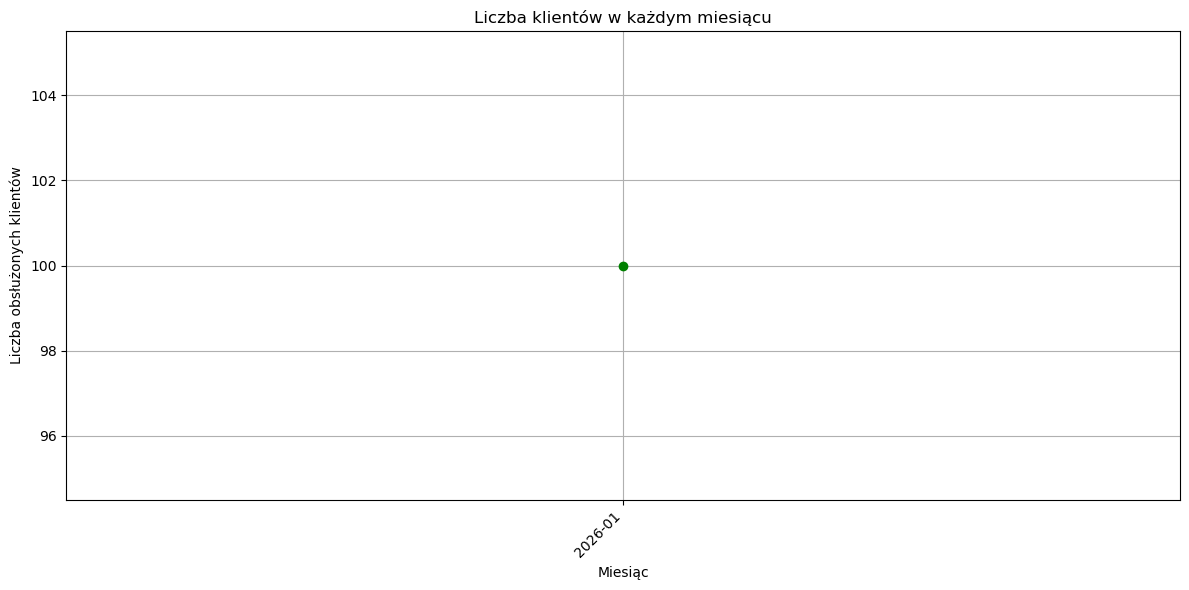

WNIOSKI
Liczba obsłużonych klientów utrzymuje się na stałym poziomie.


In [ ]:
query_clients = """
SELECT
    DATE_FORMAT(p.payment_date, '%Y-%m') AS miesiac,
    COUNT(DISTINCT pt.ticket_id) AS liczba_klientow
FROM payments p
JOIN payment_ticket pt ON p.payment_id = pt.payment_id
GROUP BY miesiac
ORDER BY miesiac
"""

baza.cursor.execute(query_clients) 
rows = baza.cursor.fetchall()

df_clients = pd.DataFrame(rows, columns=["miesiac", "liczba_klientow"])

import pandas as pd
import matplotlib.pyplot as plt

if not df_clients.empty:
    plt.figure(figsize=(12,6))
    plt.plot(df_clients["miesiac"], df_clients["liczba_klientow"], marker='o', color='green')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Miesiąc")
    plt.ylabel("Liczba obsłużonych klientów")
    plt.title("Liczba klientów w każdym miesiącu")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

  
    if df_clients["liczba_klientow"].iloc[-1] > df_clients["liczba_klientow"].iloc[0]:
        trend = "rośnie"
    elif df_clients["liczba_klientow"].iloc[-1] < df_clients["liczba_klientow"].iloc[0]:
        trend = "maleje"
    else:
        trend = "utrzymuje się na stałym poziomie"

    print("WNIOSKI")
    print(f"Liczba obsłużonych klientów {trend}.")
    


### c) Analiza bezpieczeństwa: Czy atrakcje są niebezpieczne?

W tej sekcji sprawdzamy, które atrakcje generują najwięcej incydentów i jak poważne one są.
Na tej podstawie system zarekomenduje:
- **Poprawę bezpieczeństwa** (gdy awarie są ryzykowne dla zdrowia).
- **Zwiększenie ubezpieczenia** (gdy awarie są częste, ale mało groźne).


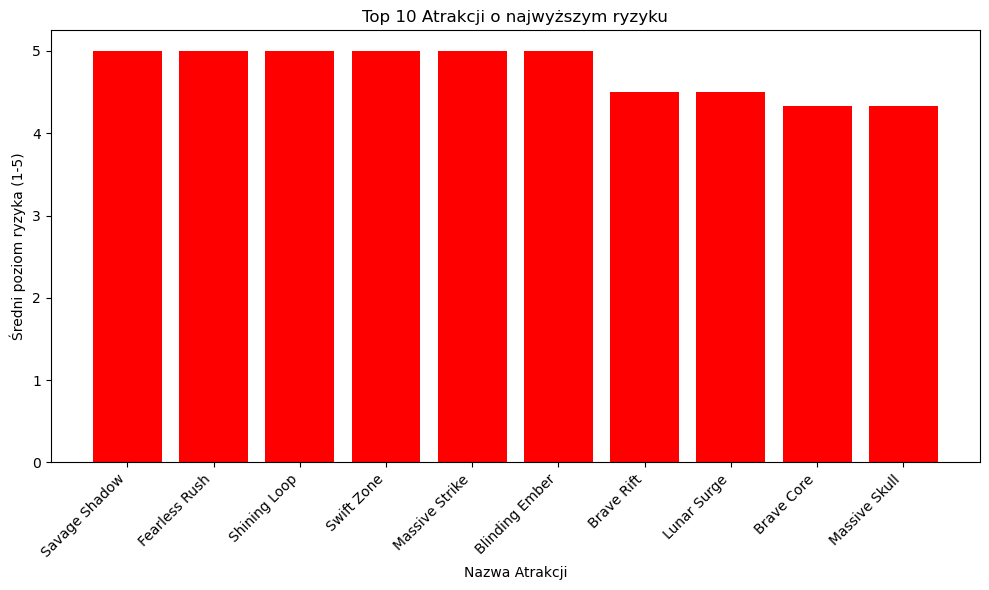

WNIOSKI
Najbardziej problematyczna: Savage Shadow (Incydenty: 2)
 DECYZJA: Atrakcja jest bardzo niebezpieczna. Zalecana natychmiastowa naprawa systemów bezpieczeństwa.


In [19]:
query_safety = """
SELECT 
    a.attraction_name,
    COUNT(i.incident_id) AS liczba_wypadkow,
    AVG(it.risk_level) AS srednie_ryzyko
FROM attractions a
JOIN incidents i ON a.attraction_id = i.attraction_id
JOIN incident_type it ON i.incident_type_id = it.incident_type_id
GROUP BY a.attraction_name
HAVING liczba_wypadkow > 0
ORDER BY srednie_ryzyko DESC, liczba_wypadkow DESC
LIMIT 10
"""

try:
    baza.cursor.execute(query_safety)
    rows = baza.cursor.fetchall()
    columns = [col[0] for col in baza.cursor.description]
    
    df_safety = pd.DataFrame(rows, columns=columns)
    df_safety['srednie_ryzyko'] = df_safety['srednie_ryzyko'].astype(float)

except Exception as e:
    print(f"Wystąpił błąd SQL: {e}")
    df_safety = pd.DataFrame()


if df_safety.empty:
    print("Brak danych o incydentach do analizy.")
else:
    plt.figure(figsize=(10, 6))

    kolory = ['red' if x > 3.5 else 'orange' for x in df_safety['srednie_ryzyko']]

    plt.bar(df_safety['attraction_name'], df_safety['srednie_ryzyko'], color=kolory)

    plt.xlabel("Nazwa Atrakcji")
    plt.ylabel("Średni poziom ryzyka (1-5)")
    plt.title("Top 10 Atrakcji o najwyższym ryzyku")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("WNIOSKI")
    najgorsza = df_safety.iloc[0]
    print(f"Najbardziej problematyczna: {najgorsza['attraction_name']} (Incydenty: {najgorsza['liczba_wypadkow']})")

    if najgorsza['srednie_ryzyko'] > 3.5:
        print(" DECYZJA: Atrakcja jest bardzo niebezpieczna. Zalecana natychmiastowa naprawa systemów bezpieczeństwa.")
    else:
        print(" DECYZJA: Ryzyko umiarkowane. Zalecane zwiększenie pakietu ubezpieczenia OC.")

### d) Analiza wieku klientów: Kto odwiedza park najczęściej?

Analiza struktury wiekowej gości pozwala dostosować ofertę marketingową.
Sprawdzamy rozkład wieku zarejestrowanych gości, aby odpowiedzieć na pytania:
- Czy park przyciąga głównie młodzież, czy rodziny z dziećmi?
- Do kogo kierować reklamy?

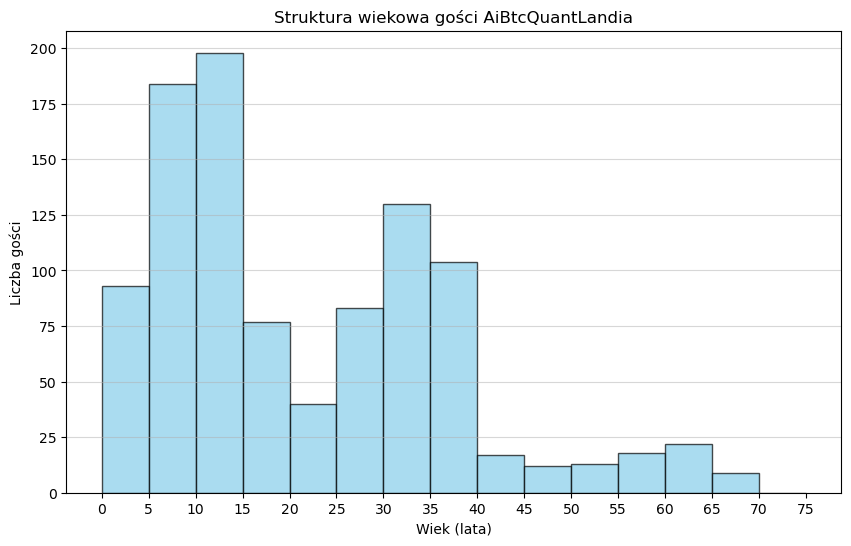

--- PROFIL KLIENTA ---
Średnia wieku gościa: 22.0 lat.
Najliczniejsza grupa wiekowa: 10-15 lat.
WNIOSEK: Park przyciąga głównie dzieci i młodzież. Zalecane kampanie na TikToku i Instagramie.


In [20]:
query_age = "SELECT birth_date FROM guests"

try:
    baza.cursor.execute(query_age)
    rows = baza.cursor.fetchall()
    df_age = pd.DataFrame(rows, columns=['birth_date'])

    df_age['birth_date'] = pd.to_datetime(df_age['birth_date'])
    now = pd.Timestamp.now()
    
    df_age['wiek'] = (now - df_age['birth_date']).dt.days / 365.25

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(df_age['wiek'], bins=range(0, 80, 5), color='skyblue', edgecolor='black', alpha=0.7)

    plt.xlabel("Wiek (lata)")
    plt.ylabel("Liczba gości")
    plt.title("Struktura wiekowa gości AiBtcQuantLandia")
    plt.grid(axis='y', alpha=0.5)
    plt.xticks(bins)
    plt.show()

    srednia_wieku = df_age['wiek'].mean()
    dominujaca_grupa_idx = n.argmax()
    dominujaca_grupa_start = bins[dominujaca_grupa_idx]
    dominujaca_grupa_end = bins[dominujaca_grupa_idx+1]

    print("--- PROFIL KLIENTA ---")
    print(f"Średnia wieku gościa: {round(srednia_wieku, 0)} lat.")
    print(f"Najliczniejsza grupa wiekowa: {int(dominujaca_grupa_start)}-{int(dominujaca_grupa_end)} lat.")
    
    if dominujaca_grupa_start < 20:
        print("WNIOSEK: Park przyciąga głównie dzieci i młodzież. Zalecane kampanie na TikToku i Instagramie.")
    elif dominujaca_grupa_start < 30:
        print("WNIOSEK: Główni klienci to młodzi dorośli. Warto promować atrakcje ekstremalne.")
    else:
        print("WNIOSEK: Park odwiedzają całe rodziny. Warto promować bilety rodzinne i strefy gastronomiczne.")

except Exception as e:
    print(f"Błąd analizy wieku: {e}")

### e) Analiza techniczna: Koszty napraw i awaryjność

Nie każda awaria kosztuje tyle samo. Czasem naprawa drobnej usterki to grosze, a innym razem jedna poważna awaria pochłania ogromne kwoty.
W tej analizie sprawdzamy, na które atrakcje park wydaje najwięcej pieniędzy w serwisie (naprawy, części i robocizna).

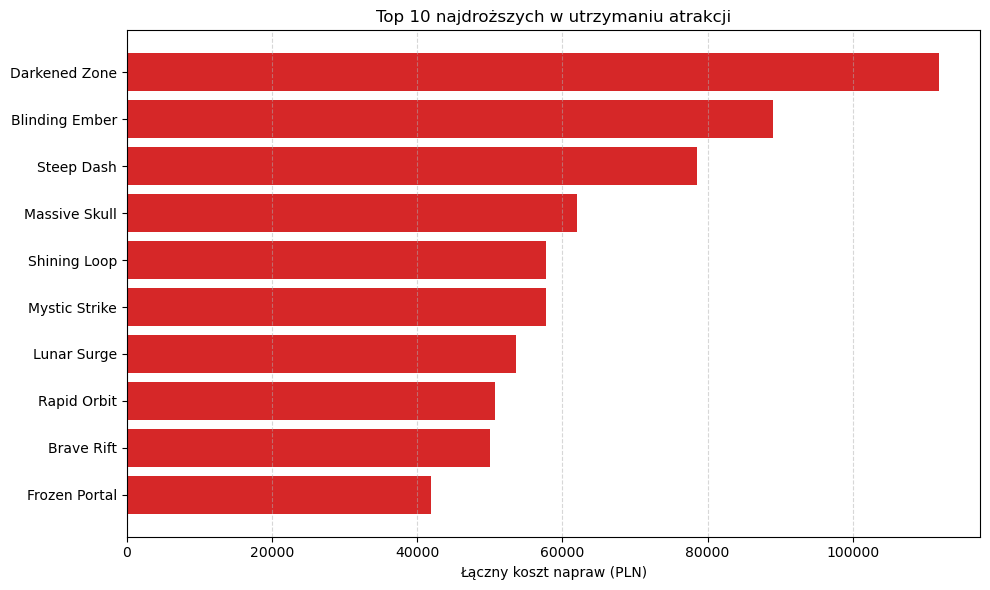

RAPORT SERWISOWY:
Najdroższa atrakcja w naprawach: Darkened Zone
Koszt całkowity: 111,931.00 PLN (przy 8 awariach)
REKOMENDACJA: Koszty są wysokie, ale w normie dla tego typu urządzeń. Należy monitorować stan techniczny.


In [29]:
query_maintenance = """
SELECT 
    a.attraction_name,
    COUNT(m.malfunction_id) as liczba_awarii,
    SUM(m.fix_cost) as laczny_koszt_napraw
FROM attractions a
JOIN malfunctions m ON a.attraction_id = m.attraction_id
GROUP BY a.attraction_name
ORDER BY laczny_koszt_napraw DESC
LIMIT 10
"""

try:
    baza.cursor.execute(query_maintenance)
    rows = baza.cursor.fetchall()
    df_maint = pd.DataFrame(rows, columns=['attraction_name', 'liczba_awarii', 'koszt'])

    df_maint['koszt'] = df_maint['koszt'].astype(float)

    if df_maint.empty:
        print("Brak danych o naprawach. Park działa idealnie!")
    else:
        plt.figure(figsize=(10, 6))
        df_plot = df_maint.sort_values('koszt', ascending=True)
        
        plt.barh(df_plot['attraction_name'], df_plot['koszt'], color='#d62728')

        plt.xlabel("Łączny koszt napraw (PLN)")
        plt.title("Top 10 najdroższych w utrzymaniu atrakcji")
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        top_fail = df_maint.iloc[0]
        avg_cost = df_maint['koszt'].mean()

        print("RAPORT SERWISOWY:")
        print(f"Najdroższa atrakcja w naprawach: {top_fail['attraction_name']}")
        print(f"Koszt całkowity: {top_fail['koszt']:,.2f} PLN (przy {top_fail['liczba_awarii']} awariach)")

        if top_fail['koszt'] > 2 * avg_cost:
            print("REKOMENDACJA: Atrakcja generuje krytyczne obciążenie budżetowe. Należy rozważyć jej zamknięcie lub gruntowną modernizację.")
        else:
            print("REKOMENDACJA: Koszty są wysokie, ale w normie dla tego typu urządzeń. Należy monitorować stan techniczny.")

except Exception as e:
    print(f"Błąd analizy kosztów: {e}")

### f) Analiza HR: Efektywność pracowników i zwrot z inwestycji (ROI)

W tej sekcji analizujemy **produktywność zespołów** obsługujących poszczególne atrakcje.
Obliczamy wskaźnik ROI (Return on Investment) dla kapitału ludzkiego, aby odpowiedzieć na pytania:
- Ile złotych przychodu generuje każda 1 złotówka wydana na pensje?
- Gdzie występuje przerost zatrudnienia względem generowanych zysków?

In [ ]:
try:
    query_hr = """
    SELECT 
        attraction_id,
        COUNT(employee_id) as liczba_pracownikow,
        SUM(salary) as koszt_pensji
    FROM employees
    GROUP BY attraction_id
    """
    baza.cursor.execute(query_hr)
    df_hr = pd.DataFrame(baza.cursor.fetchall(), columns=['id', 'liczba_pracownikow', 'koszt_pensji'])

    query_rev = """
    SELECT 
        a.attraction_id as id,
        a.attraction_name,
        COALESCE(SUM(pr.amount), 0) as przychod
    FROM attractions a
    LEFT JOIN prices pr ON a.attraction_id = pr.attraction_id
    LEFT JOIN payment_ticket pt ON pr.ticket_id = pt.ticket_id
    GROUP BY a.attraction_id, a.attraction_name
    """
    baza.cursor.execute(query_rev)
    df_rev = pd.DataFrame(baza.cursor.fetchall(), columns=['id', 'name', 'przychod'])

    df_roi = df_rev.merge(df_hr, on='id')

    df_roi['przychod'] = df_roi['przychod'].astype(float)
    df_roi['koszt_pensji'] = df_roi['koszt_pensji'].astype(float)

    df_roi['wskaznik_roi'] = df_roi.apply(lambda x: x['przychod'] / x['koszt_pensji'] if x['koszt_pensji'] > 0 else 0, axis=1)

    df_roi = df_roi.sort_values('wskaznik_roi', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    
    colors = []
    for val in df_roi['wskaznik_roi']:
        if val > 3.0: colors.append('#66bb6a') # Zielony
        elif val > 1.0: colors.append('#ffee58') # Żółty
        else: colors.append('#ef5350') # Czerwony

    bars = plt.bar(df_roi['name'], df_roi['wskaznik_roi'], color=colors, edgecolor='grey')

    plt.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Próg rentowności pracowniczej (1.0)')
    plt.xlabel("Atrakcja")
    plt.ylabel("Przychód na 1 zł pensji")
    plt.title("Efektywność HR: Ile firma zarabia na każdej złotówce wydanej na pensje?")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    najlepsza = df_roi.iloc[0]
    najgorsza = df_roi.iloc[-1]

    print("--- RAPORT HR ---")
    print(f" Lider efektywności: {najlepsza['name']}")
    print(f"   Każda wydana złotówka na pensję wraca jako {round(najlepsza['wskaznik_roi'], 2)} zł przychodu.")
    
    avg_roi = df_roi['wskaznik_roi'].mean()
    print(f"Średnia efektywność dla Top 10: {round(avg_roi, 2)}")

    if avg_roi > 2.0:
        print("WNIOSEK: Zespół jest wysoce produktywny. Koszty pracy są niskie w porównaniu do zysków.")
    else:
        print("WNIOSEK: Koszty pracy są wysokie. Należy rozważyć optymalizację grafiku lub automatyzację.")

except Exception as e:
    print(f"Błąd analizy HR: {e}")

### h) Czy atrakcje VR generują większy przychód niż tradycyjne?

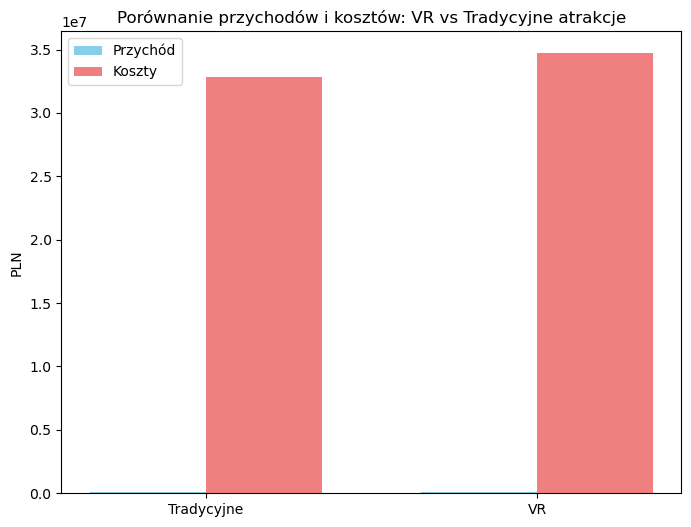

WNIOSKI:
Atrakcja najbardziej opłacalna: Tradycyjna (Zysk: -32721384.92 PLN)
 DECYZJA: Tradycyjne atrakcje przynoszą większy zysk. Warto je rozwijać i optymalizować.


In [ ]:
query_vr = """
SELECT 
    vr, 
    SUM(p.amount) AS przychod,
    SUM(c.amount) AS koszty
FROM attractions a
LEFT JOIN prices pr ON a.attraction_id = pr.attraction_id
LEFT JOIN payment_ticket pt ON pr.ticket_id = pt.ticket_id
LEFT JOIN payments p ON pt.payment_id = p.payment_id
LEFT JOIN costs c ON a.attraction_id = c.attraction_id
GROUP BY vr
"""

baza.cursor.execute(query_vr)
rows = baza.cursor.fetchall()

df_vr = pd.DataFrame(rows, columns=["VR", "przychod", "koszty"])
df_vr["zysk"] = df_vr["przychod"] - df_vr["koszty"]

import numpy as np
import matplotlib.pyplot as plt


df_vr["typ"] = df_vr["VR"].map({0: "Tradycyjne", 1: "VR"})


x = np.arange(len(df_vr)) 
width = 0.35  
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x - width/2, df_vr["przychod"], width, label="Przychód", color='skyblue')
ax.bar(x + width/2, df_vr["koszty"], width, label="Koszty", color='lightcoral')
ax.set_xticks(x)
ax.set_xticklabels(df_vr["typ"])
ax.set_ylabel("PLN")
ax.set_title("Porównanie przychodów i kosztów: VR vs Tradycyjne atrakcje")
ax.legend()
plt.show()

najlepsza = df_vr.sort_values("zysk", ascending=False).iloc[0]
print("WNIOSKI:")
print(f"Atrakcja najbardziej opłacalna: {'VR' if najlepsza['VR']==1 else 'Tradycyjna'} (Zysk: {najlepsza['zysk']:.2f} PLN)")
